# Visualization

Below we are going to demonstrate the capability that we ran through docker

In [1]:
from os.path import join
from os.path import abspath, basename, dirname, isabs, isfile

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from hydromt_sfincs import SfincsModel, utils

### Step 0: Run imports and define model

In [2]:
sfincs_root = "/app/data/SFINCS/ngwpc_data"
mod = SfincsModel(sfincs_root, mode="r")

In [3]:
import xarray as xr
ds = xr.open_dataset("/app/data/SFINCS/ngwpc_data/sfincs_map.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 142MB
Dimensions:        (n: 499, m: 199, corner_n: 500, corner_m: 200, time: 169,
                    timemax: 7, runtime: 1)
Coordinates:
    x              (n, m) float32 397kB ...
    y              (n, m) float32 397kB ...
  * time           (time) datetime64[ns] 1kB 2019-05-20 ... 2019-05-27
  * timemax        (timemax) datetime64[ns] 56B 2019-05-21 ... 2019-05-27
Dimensions without coordinates: n, m, corner_n, corner_m, runtime
Data variables: (12/13)
    inp            int32 4B ...
    corner_x       (corner_n, corner_m) float32 400kB ...
    corner_y       (corner_n, corner_m) float32 400kB ...
    crs            int32 4B ...
    sfincsgrid     int32 4B ...
    msk            (n, m) float32 397kB ...
    ...             ...
    zs             (time, n, m) float32 67MB ...
    h              (time, n, m) float32 67MB ...
    zsmax          (timemax, n, m) float32 3MB ...
    hmax           (timemax, n, m) float32 3MB ...
    total_runtime  (runtime) float32 4B ...
    average_dt     (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.8.1 of Sep 29 2021 09:36:14 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: v2.0.3-Cauberg
    Build-Date:                          $Date: 2023-11-15
    title:                               SFINCS map netcdf output

In [4]:
fn_map="sfincs_map.nc"
if not isabs(fn_map):
    fn_map = join(mod.root, fn_map)
if isfile(fn_map):
    ds_face, ds_edge = utils.read_sfincs_map_results(
        fn_map,
        ds_like=mod.grid,
        drop=["crs", "sfincsgrid"],
        logger=mod.logger,
    )
mod.set_results(ds_face, split_dataset=True)
mod.set_results(ds_edge, split_dataset=True)

### Step 1: Plot maximum flooding extent 

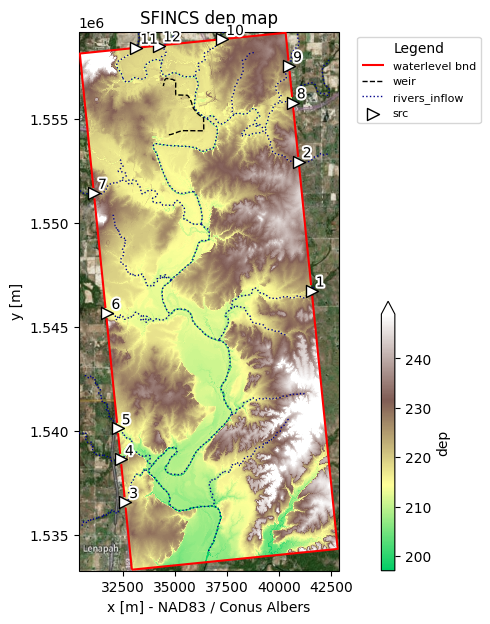

In [5]:
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

In [6]:
mod.write_raster("results.hmax", compress="LZW")

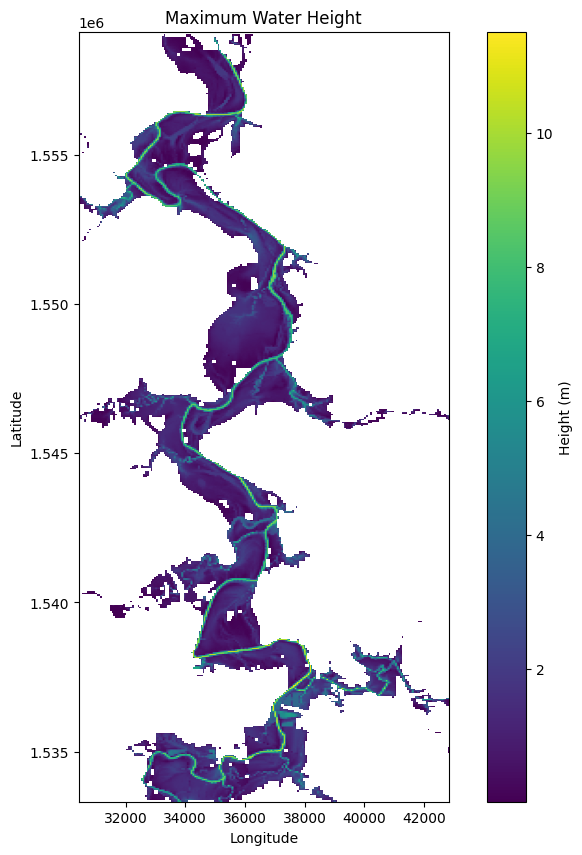

In [7]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open the file
with rasterio.open("/app/data/SFINCS/ngwpc_data/gis/hmax.tif") as src:
    # Read the data
    data = src.read(1)  # Read the first band
    
    # Get the bounds of the image
    bounds = src.bounds
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the image
    im = ax.imshow(data, cmap='viridis', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Height (m)')
    
    # Set title and labels
    ax.set_title('Maximum Water Height')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Show the plot
    plt.show()

### Show flooding over time

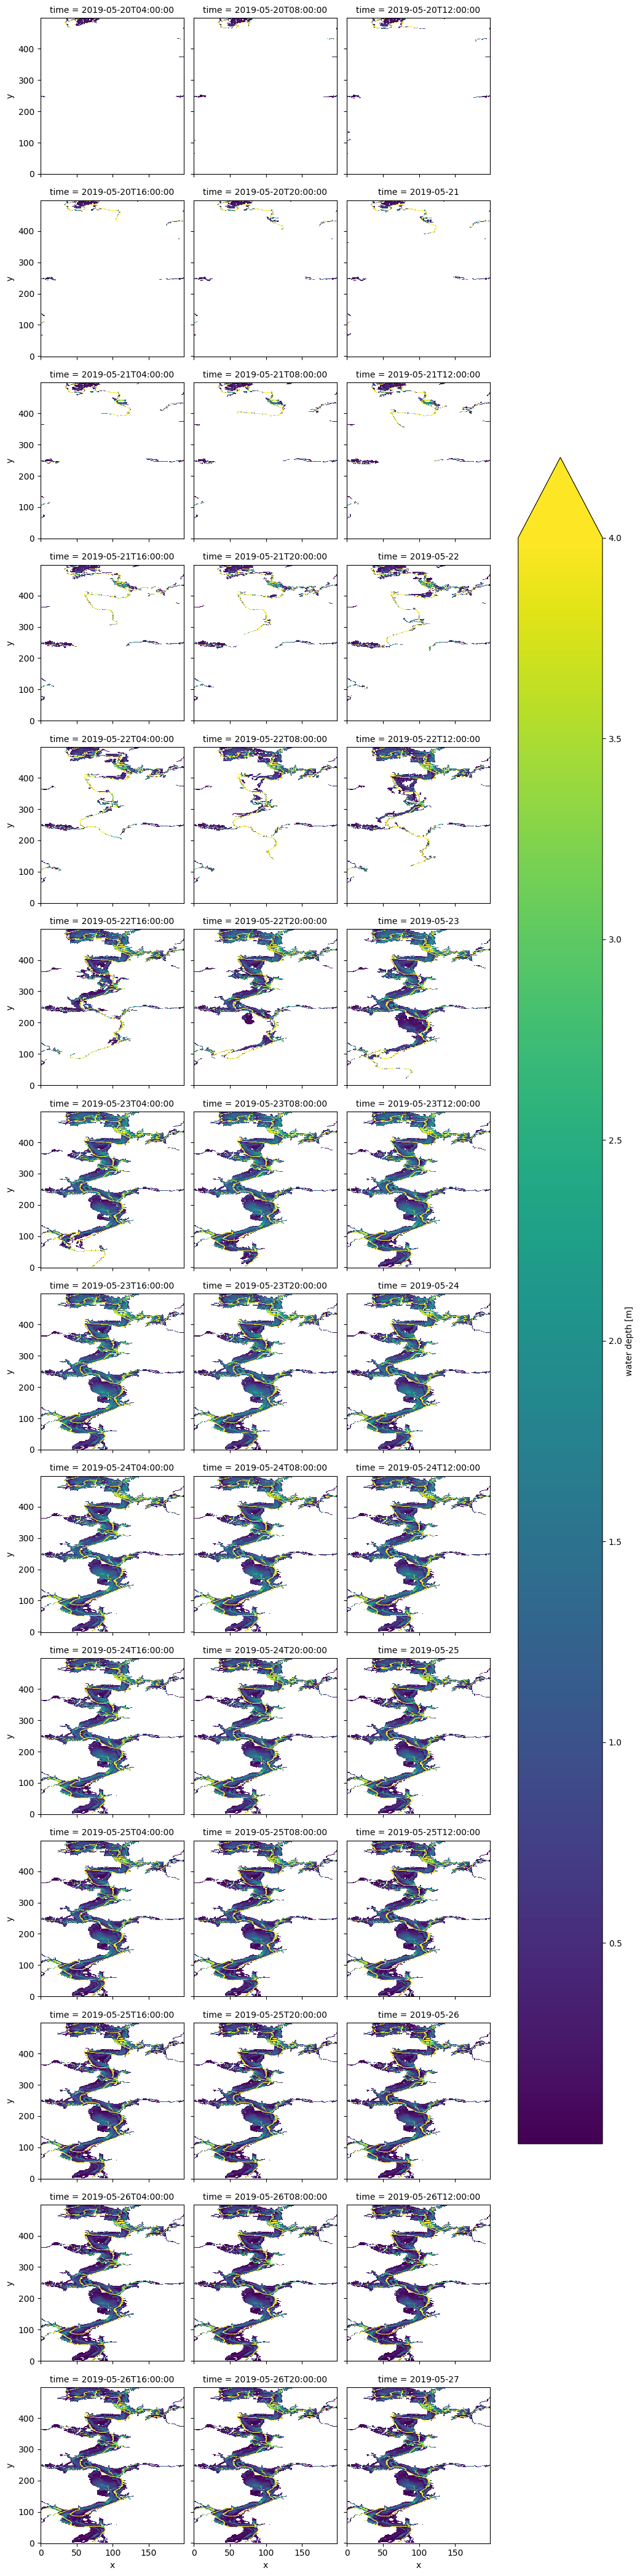

In [8]:
# h from sfincs_map contains the water depths for each cell face
# here we plot the water level every 4th hour
h = mod.results["h"].where(mod.results["h"] > 0)
h.attrs.update(long_name="water depth", unit="m")
h.sel(time=h["time"].values[4::4]).plot(col="time", col_wrap=3, vmax=4)

In [9]:
# mask water depth
hmin = 0.05
da_h = mod.results["h"].copy()
da_h = da_h.where(da_h > hmin).drop("spatial_ref")
da_h.attrs.update(long_name="flood depth", unit="m")

In [10]:
!sudo apt-get install -y ffmpeg
!pip install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf fontconfig i965-va-driver
  intel-media-va-driver libaacs0 libaom3 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec58 libavdevice58 libavfilter7
  libavformat58 libavutil56 libbdplus0 libblas3 libbluray2 libbs2b0 libcaca0
  libcairo-gobject2 libcdio-cdda2 libcdio-paranoia2 libcdio19 libchromaprint1
  libcodec2-1.0 libdatrie1 libdav1d5 libdc1394-25 libdecor-0-0
  libdecor-0-plugin-1-cairo libdeflate0 libdrm-amdgpu1 libdrm-common
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libdrm2 libflac8 libflite1
  libfribidi0 libgbm1 libgdk-pixbuf-2.0-0 libgdk-pixbuf2.0-bin
  libgdk-pixbuf2.0-common libgfortran5 libgl1 libgl1-amber-dri libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgme0 libgomp1 libgsm1
  libiec61883-0 libigdgmm12 libjack-jackd2-0 libjbig0 libjpeg-turbo8 li

In [11]:
# create hmax plot and save to mod.root/figs/sfincs_h.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
from matplotlib import animation

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}


def update_plot(i, da_h, cax_h):
    da_hi = da_h.isel(time=i)
    t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_hi.values.ravel())


fig, ax = mod.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(11, 7)
)
cax_h = da_h.isel(time=0).plot(
    x="xc", y="yc",
    ax=ax,
    vmin=0, vmax=3,
    cmap=plt.cm.viridis,
    cbar_kwargs=cbar_kwargs
)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_h.time.size, step),
    interval=250,  # ms between frames
    fargs=(
        da_h,
        cax_h,
    ),
)

# to save to mp4
ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
# from IPython.display import HTML

# HTML(ani.to_html5_video())